# Decay curve of the central spin under driving

**Yuning Zhang, TU Delft, 2021.10.23**

In [3]:
using Plots
using LsqFit
import ProgressMeter: @showprogress
include("SpinEnsemble.jl")

t_adaptive

use moving average function to smoothen the sampled curve

In [4]:
"""
Standard moving average function, with given order and filling option
========================
Args:
    vs: data array 
    n: number of data for smoothing
    order: `:backward` or ':forward', smoothing start from begning/ending of the array
    fill: option, wether to fill the missed data points to keep the array at same length
Return:
    a smoothened array
"""
function moving_average(vs::AbstractArray{<:Number},n::Int; order=:backward, fill=:true)
    l=length(vs)
    if order==:forward
        ma=[sum(vs[i:(i+n-1)])/n for i in 1:l-n+1 ]
        if fill append!(ma,[mean(vs[i:l]) for i in l-n+2:l]) end
        return ma
    elseif order==:backward
        ma=[sum(vs[i-(n-1):i])/n for i in n:l]
        if fill prepend!(ma,[mean(vs[1:i]) for i in 1:n-1]) end
        return ma
    else
        println("Invalid order option")
    end
end;

generate an ensemble of 100 spins, set transverse magnetic field to 2, simulate the dynamics using Monte-Carlo sampling

set sampling size to 10000

In [76]:
N=200
D=rand_bath_dipolar_coefs(N,3);
T=t_adaptive(D,200,len=300)
# T=0:1e-4:1e-2
h=2;

set sampling size to 100

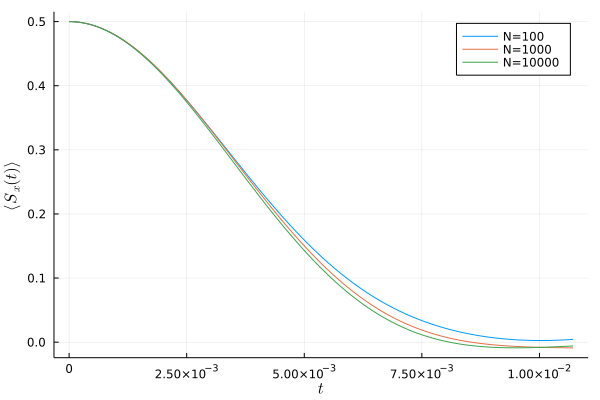

In [89]:
fig=plot()
for N in [100,10^3,10^4]
    f_t,f_var=f_sampling(T,D,h;N=N) 
    plot!(T,f_t;FID_plot_options...,labels="N=$N")
end
display(fig)

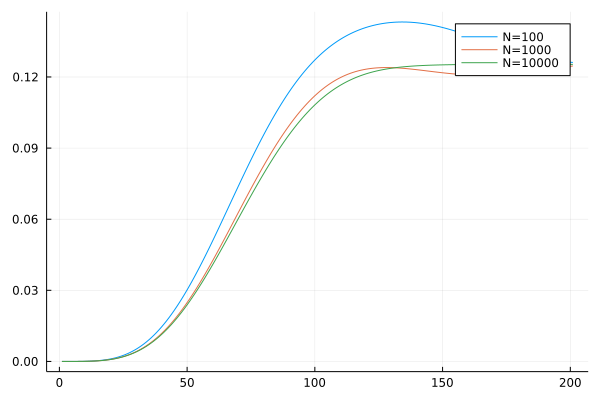

In [90]:
vars=[]
var_plot=plot()
sampling_size=[100,10^3,10^4]
for k in sampling_size
    f_t,f_var=f_sampling(T,D,h;N=k) 
    push!(vars,f_var)
    plot!(f_var,labels="N=$k")
end
display(var_plot)

## Average decaying curve under driving

In [85]:
K=100
M=10^3
T=t_adaptive(D,300,len=200)
averaged_f=:void
@showprogress for i in 1:K
    D=rand_bath_dipolar_coefs(N,3)
    f_t,f_var=f_sampling(T,D,h;N=M) 
    if averaged_f==:void
        averaged_f=f_t/K
    else
        averaged_f+=f_t/K
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


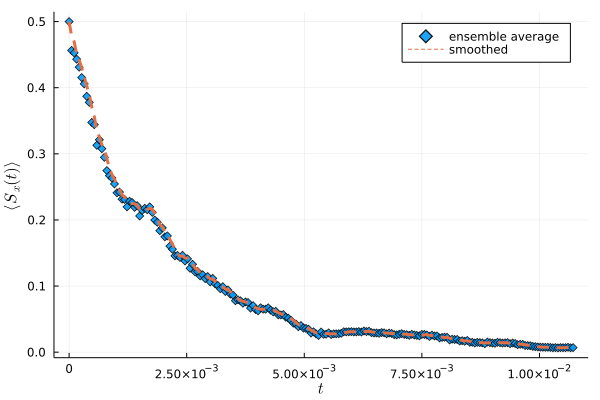

In [86]:
scatter(T,averaged_f;FID_plot_options...,labels="ensemble average", 
    markershape = :d,
    markersize = 4,
    markeralpha = 0.9,
)
plot!(T,moving_average(averaged_f,3),linestyle = :dash, linewidth=3, label="smoothed")

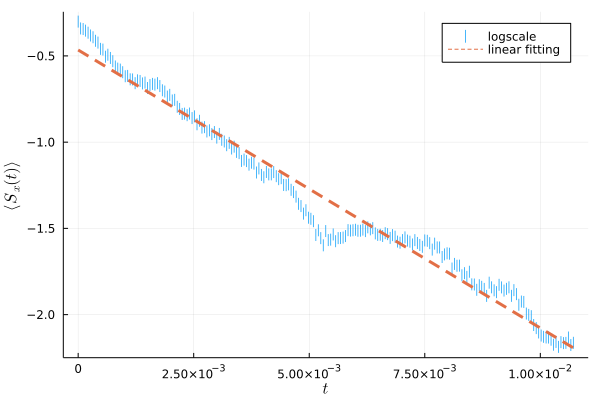

In [87]:
cutoff=length(T)
X=T[1:cutoff]
Y=(averaged_f)[1:cutoff]
m(t,p)=p[1]*t.+p[2]
p0=[-1.0,0.0]
fit = curve_fit(m, X, log10.(Y), p0);

scatter(X,log10.(Y);FID_plot_options...,labels="logscale", 
    markershape = :vline,
    markersize = 6,
    markeralpha = 0.9,
#     markercolor=:red,
)
plot!(X,m(X,fit.param),linestyle=:dash,linewidth=3,label="linear fitting")

## Analysis on the mean variance

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


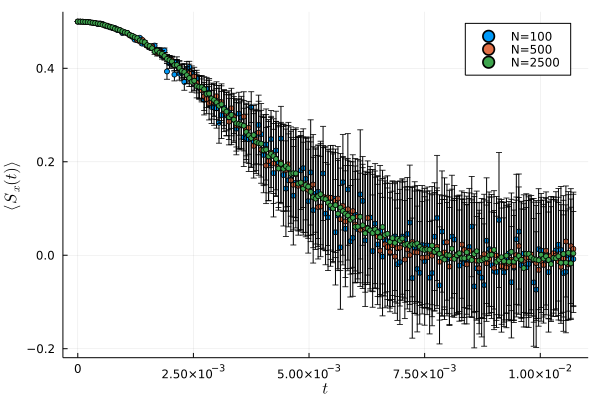

In [275]:
# plot the decay curve using the direct production
sampling_size=[100,500,2500]
fig=plot()
for k in sampling_size
    fid=@showprogress map(t->f_sampling(t,D,h;N=k),T)
    scatter!(T,[x[1] for x in fid],yerrors=[x[2] for x in fid],markersize=3;FID_plot_options...,labels="N=$k")
end
display(fig)

In [299]:
sampling_size=300:100:3000
# t=T[150]
M=length(sampling_size)
f_var=zeros(M)
@showprogress for i in 1:M
    arr=[f_sampling(t,D,h;N=sampling_size[i])[1] for t in rand(T[150:151],100)]
    f_var[i]=var(arr)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


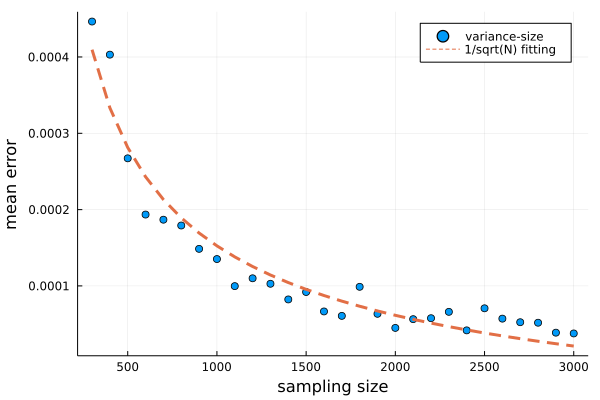

In [338]:
scatter(sampling_size,f_var,label="variance-size")
error_model(N,p)=p[1]./sqrt.(N.-1).+p[2]
fit = curve_fit(error_model, sampling_size, f_var, [1.0,0.0])
plot!(sampling_size,error_model(sampling_size,fit.param),linestyle=:dash,linewidth=3,
#     yerrors=fit.resid,
    xlabel="sampling size",
    ylabel="mean error",
    label="1/sqrt(N) fitting ")

In [339]:
println("fitting parameters: ",fit.param)

fitting parameters: [0.009815081571386912, -0.00015805038520792068]


In [340]:
println("fitting error: ", sum(fit.resid.^2))

fitting error: 1.799179447735085e-8
